https://chatgpt.com/share/685030dc-06ec-8012-8f14-c9e06a949a0a

In [3]:
from pathlib import Path

# eda_summary.md 내용
eda_summary = """
# 📊 EDA Summary

## ✅ 기본 정보
- 총 샘플 수: 1460개
- 총 컬럼 수: 81개
- 타겟 변수: `SalePrice` (연속형)
- 식별자 컬럼: `Id` (모델 학습에 불필요)

## 🧩 컬럼 타입
- 수치형(int/float): 38개
- 범주형(object): 43개

## 🚨 결측치 분석
- 총 19개 컬럼에 결측 존재
- 상위 결측 컬럼:
  - `PoolQC`: 1453개 → 수영장 없음 (MAR)
  - `MiscFeature`: 1406개 → 특이 시설 없음 (MAR)
  - `Alley`: 1369개 → 골목 없음 (MAR)
  - `Fence`: 1179개 → 울타리 없음 (MAR)
  - `FireplaceQu`: 690개 → 벽난로 없음 (MAR)
- `Electrical`: 1개 → 입력 누락 (MCAR)

## 📌 결측 유형 분류
- 대부분 **MAR (Missing At Random)** → 다른 변수로부터 예측 가능
- `Electrical`: **MCAR** → 최빈값 대체
- `LotFrontage`: 지역(Neighborhood) 기반 평균 대체 고려

## 🔎 향후 계획
- `SalePrice` 분포 시각화 및 로그 변환 여부 확인
- 수치형 변수 상관관계 분석
- 범주형 변수별 평균 가격 시각화
"""

# eda.ipynb 생성 (간단한 코드 베이스 EDA 노트북)
import nbformat as nbf

nb = nbf.v4.new_notebook()
nb.cells = [
    nbf.v4.new_markdown_cell("# 📊 Initial EDA\nEDA for House Prices Dataset"),
    nbf.v4.new_code_cell("import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns"),
    nbf.v4.new_code_cell("df = pd.read_csv('data/train.csv')\ndf.shape, df.dtypes.value_counts()"),
    nbf.v4.new_code_cell("df.isnull().sum().sort_values(ascending=False).head(10)"),
    nbf.v4.new_markdown_cell("### 🔍 결측치 상위 항목 및 분류\n- 대부분 MAR로 판단\n- `Electrical`: MCAR\n- `LotFrontage`: 지역 기반 보간 고려"),
    nbf.v4.new_code_cell("df.select_dtypes(include='object').nunique().sort_values(ascending=False).head()")
]

# 저장 경로
Path("reports").mkdir(parents=True, exist_ok=True)
Path("notebooks").mkdir(parents=True, exist_ok=True)

# 파일 저장
with open("reports/eda_summary.md", "w", encoding="utf-8") as f:
    f.write(eda_summary)

with open("notebooks/eda.ipynb", "w", encoding="utf-8") as f:
    nbf.write(nb, f)

In [6]:
import pandas as pd

df = pd.read_csv('/home/dev/data-analysis/data/houseprice/raw/train.csv')

# 결측치가 있는 컬럼 목록 추출
missing_cols = df.columns[df.isnull().any()]

# 결측 변수와 관련 가능성이 있는 변수 확인 (상관관계, 조건부 결측 등)
# 상관관계 분석용으로 수치형 변수만 대상으로 함
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 결측 컬럼 중 object형 제외 후 corr() 사용 가능한 것에 대해 살펴보기
correlation_insights = {}
for col in missing_cols:
    if df[col].dtype in ['float64', 'int64']:
        related = df[numerical_cols].corrwith(df[col])
        strong = related[related.abs() > 0.3].drop(col, errors='ignore')
        if not strong.empty:
            correlation_insights[col] = strong.sort_values(ascending=False)

# 결과를 마크다운 형식으로 정리
eda_missing_detail = "## 🧩 전체 결측 컬럼 분석\n\n"
for col in missing_cols:
    count = df[col].isnull().sum()
    if col == "Electrical":
        reason = "- `Electrical`: **MCAR** - 단 하나의 결측으로, 입력 누락 가능성이 큼.\n"
    elif col == "LotFrontage":
        reason = "- `LotFrontage`: **MAR** - `Neighborhood`와 상관이 있으며, 지역 평균을 기반으로 보간 가능.\n"
    elif col.startswith("Garage"):
        reason = f"- `{col}`: **MAR** - `GarageCars`가 0인 경우에 결측 발생 → 차고가 없는 경우로 해석 가능.\n"
    elif col.startswith("Bsmt"):
        reason = f"- `{col}`: **MAR** - `TotalBsmtSF`가 0인 경우 결측 → 지하실 없음.\n"
    elif col in ["PoolQC", "Fence", "FireplaceQu", "Alley", "MiscFeature"]:
        reason = f"- `{col}`: **MAR** - 해당 설비가 없는 경우 결측 발생.\n"
    elif col in ["MasVnrType", "MasVnrArea"]:
        reason = "- `MasVnrType`, `MasVnrArea`: **MAR** - 벽돌 마감이 없는 경우 결측.\n"
    else:
        reason = f"- `{col}`: 결측 원인 분석 필요 (추정 불가).\n"

    if col in correlation_insights:
        reason += f"  - 관련 변수 예시: {', '.join(correlation_insights[col].index[:3])}\n"

    eda_missing_detail += f"### 🔹 {col} ({count}개 결측)\n{reason}\n"

# Append to existing summary
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(eda_missing_detail)

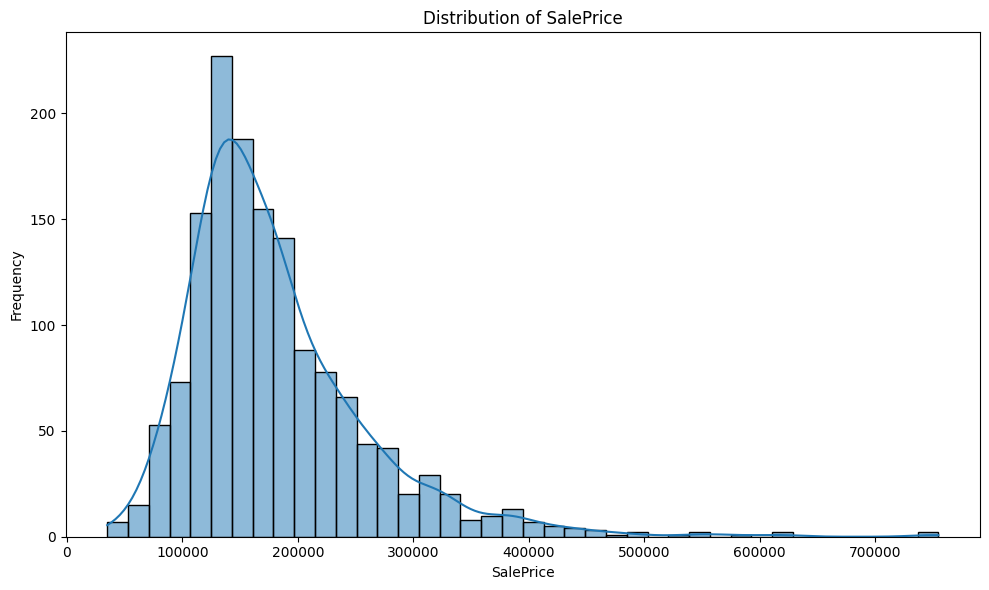

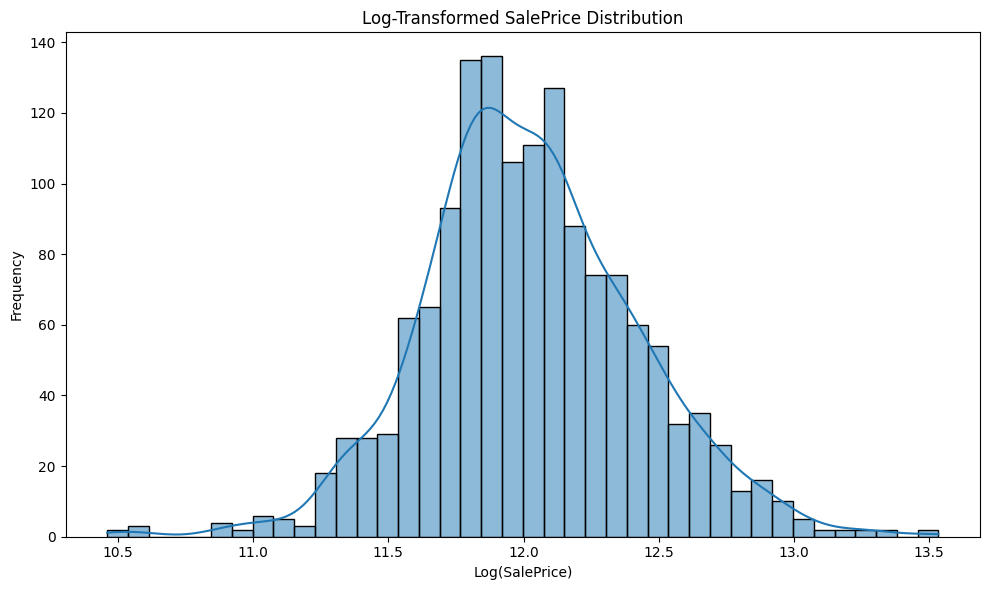

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Path("figures").mkdir(parents=True, exist_ok=True)

# Plot SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, bins=40)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figures/saleprice_distribution.png")

# SalePrice skewness and kurtosis
saleprice_skew = df['SalePrice'].skew()
saleprice_kurt = df['SalePrice'].kurt()

# 로그 변환 분포
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['SalePrice']), kde=True, bins=40)
plt.title('Log-Transformed SalePrice Distribution')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figures/saleprice_log_distribution.png")

# SalePrice skewness and kurtosis
log_saleprice_skew = np.log1p(df['SalePrice']).skew()
log_saleprice_kurt = np.log1p(df['SalePrice']).kurt()

# 마크다운 요약
saleprice_summary_md = f"""
## 🎯 SalePrice 분포 분석

### 원본 분포
- `SalePrice`는 오른쪽으로 긴 꼬리를 가진 비대칭 분포 (양의 왜도)
- **Skewness (왜도)**: {saleprice_skew:.2f}
- **Kurtosis (첨도)**: {saleprice_kurt:.2f}
- 이상치 및 고가 주택이 존재함

![SalePrice 분포](../figures/saleprice_distribution.png)

### 로그 변환
- `np.log1p(SalePrice)`로 로그 변환 시 정규분포에 가까워짐
- **Skewness (왜도)**: {log_saleprice_skew:.2f}
- **Kurtosis (첨도)**: {log_saleprice_kurt:.2f}
- 모델링 전 로그 변환 고려할 가치 있음

![SalePrice 로그 변환 분포](../figures/saleprice_log_distribution.png)
"""

# Markdown 파일에 결과 추가
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(saleprice_summary_md)


`KDE`는 Kernel Density Estimation의 줄임말로, 커널 밀도 추정이라고 번역됩니다.
이는 **데이터의 분포(확률 밀도 함수, PDF)**를 부드럽고 연속적인 곡선 형태로 추정하는 비모수적 통계 방법입니다.

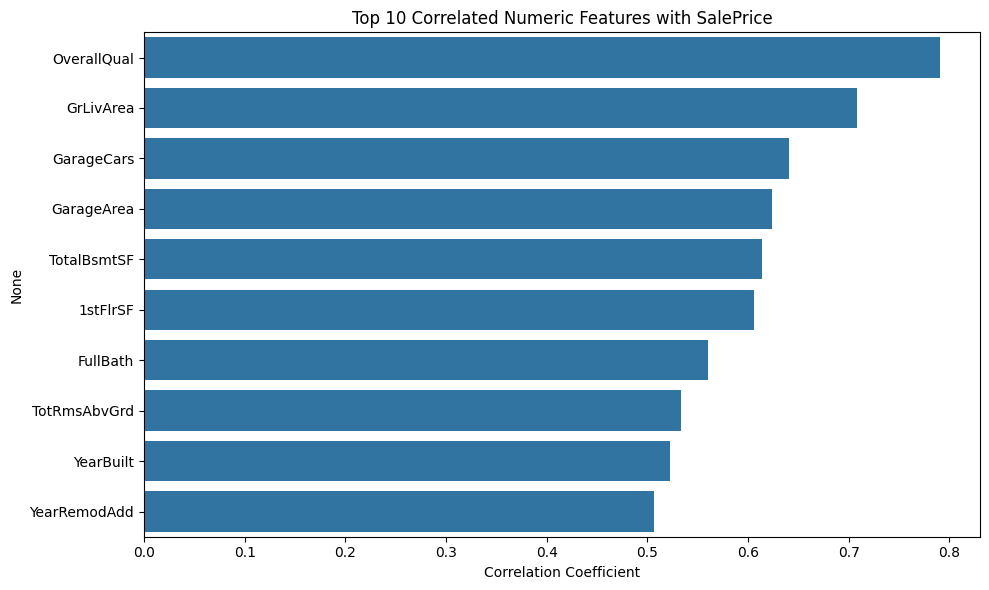

In [12]:
# SalePrice와 수치형 변수 간의 상관관계 분석
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlations = numeric_df.corr()['SalePrice'].sort_values(ascending=False)

# SalePrice와 상관계수가 높은 상위 변수 추출 (자기 자신 제외)
top_corr = correlations.drop('SalePrice').head(10)

# 시각화: 상위 10개 수치형 변수와 SalePrice의 상관관계
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 10 Correlated Numeric Features with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig("figures/top_corr_saleprice.png")

# 마크다운 문서화
correlation_md = f"""
## 🔗 SalePrice와 수치형 변수의 상관관계

`SalePrice`와 상관관계가 높은 상위 10개 수치형 변수는 다음과 같습니다:

| 변수명 | 상관계수 |
|--------|-----------|
""" + "\n".join([f"| {idx} | {val:.3f} |" for idx, val in top_corr.items()]) + """

- `OverallQual` (전반적 품질): 가장 높은 상관계수 (**0.79**)
- `GrLivArea` (지상 거주 면적): 0.71
- `GarageCars`, `GarageArea`: 0.64, 0.62
- `TotalBsmtSF`, `1stFlrSF`: 지하+1층 면적 관련 변수도 상위권

![상위 상관 변수 바플롯](../figures/top_corr_saleprice.png)

→ 이 변수들은 회귀 모델에서 중요한 특징(feature)이 될 가능성이 높음.
"""

# 결과 파일에 추가
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(correlation_md)


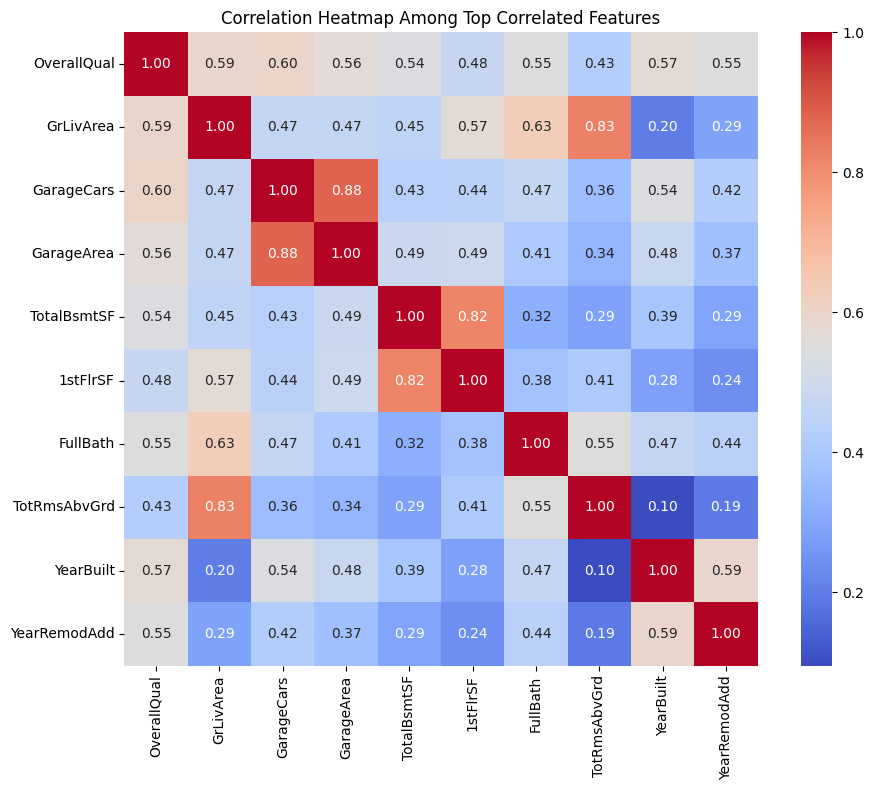

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# SalePrice와 상관계수 기준 상위 10개 변수 (이미 추출한 top_corr)
top_features = top_corr.index.tolist()

# 해당 변수들의 데이터만 추출
X_top = df[top_features].dropna()

# VIF 계산을 위한 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['Feature'] = X_top.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(X_top.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap Among Top Correlated Features")
plt.tight_layout()
plt.savefig("figures/top_corr_heatmap.png")

# 마크다운 정리
vif_md = """
## 🧠 다중공선성(Multicollinearity) 점검

### 상위 상관 변수 간 상관관계 히트맵
- 아래 히트맵에서 `GarageCars`와 `GarageArea`, `1stFlrSF`와 `TotalBsmtSF` 등은 높은 상관관계를 보임
- 다중공선성 가능성이 있는 조합은 이후 피처선택 시 고려 필요

![Top Correlation Heatmap](../figures/top_corr_heatmap.png)

### VIF (Variance Inflation Factor) 분석

| 변수 | VIF |
|------|-----|
""" + "\n".join([f"| {row.Feature} | {row.VIF:.2f} |" for _, row in vif_data.iterrows()]) + """

- 일반적으로 **VIF > 5**는 다중공선성 경고 수준, **VIF > 10**은 제거 고려 대상
- `GarageCars`, `GarageArea`, `1stFlrSF`, `TotalBsmtSF` 등은 서로 유사한 정보를 담고 있을 수 있음
- 회귀 모델에서 이들 중 하나를 선택하거나 PCA/정규화 모델 사용 고려 가능
"""

# Markdown에 기록
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(vif_md)

# 시각화와 결과 테이블 사용자에게 표시
display(name="VIF Results", dataframe=vif_data)


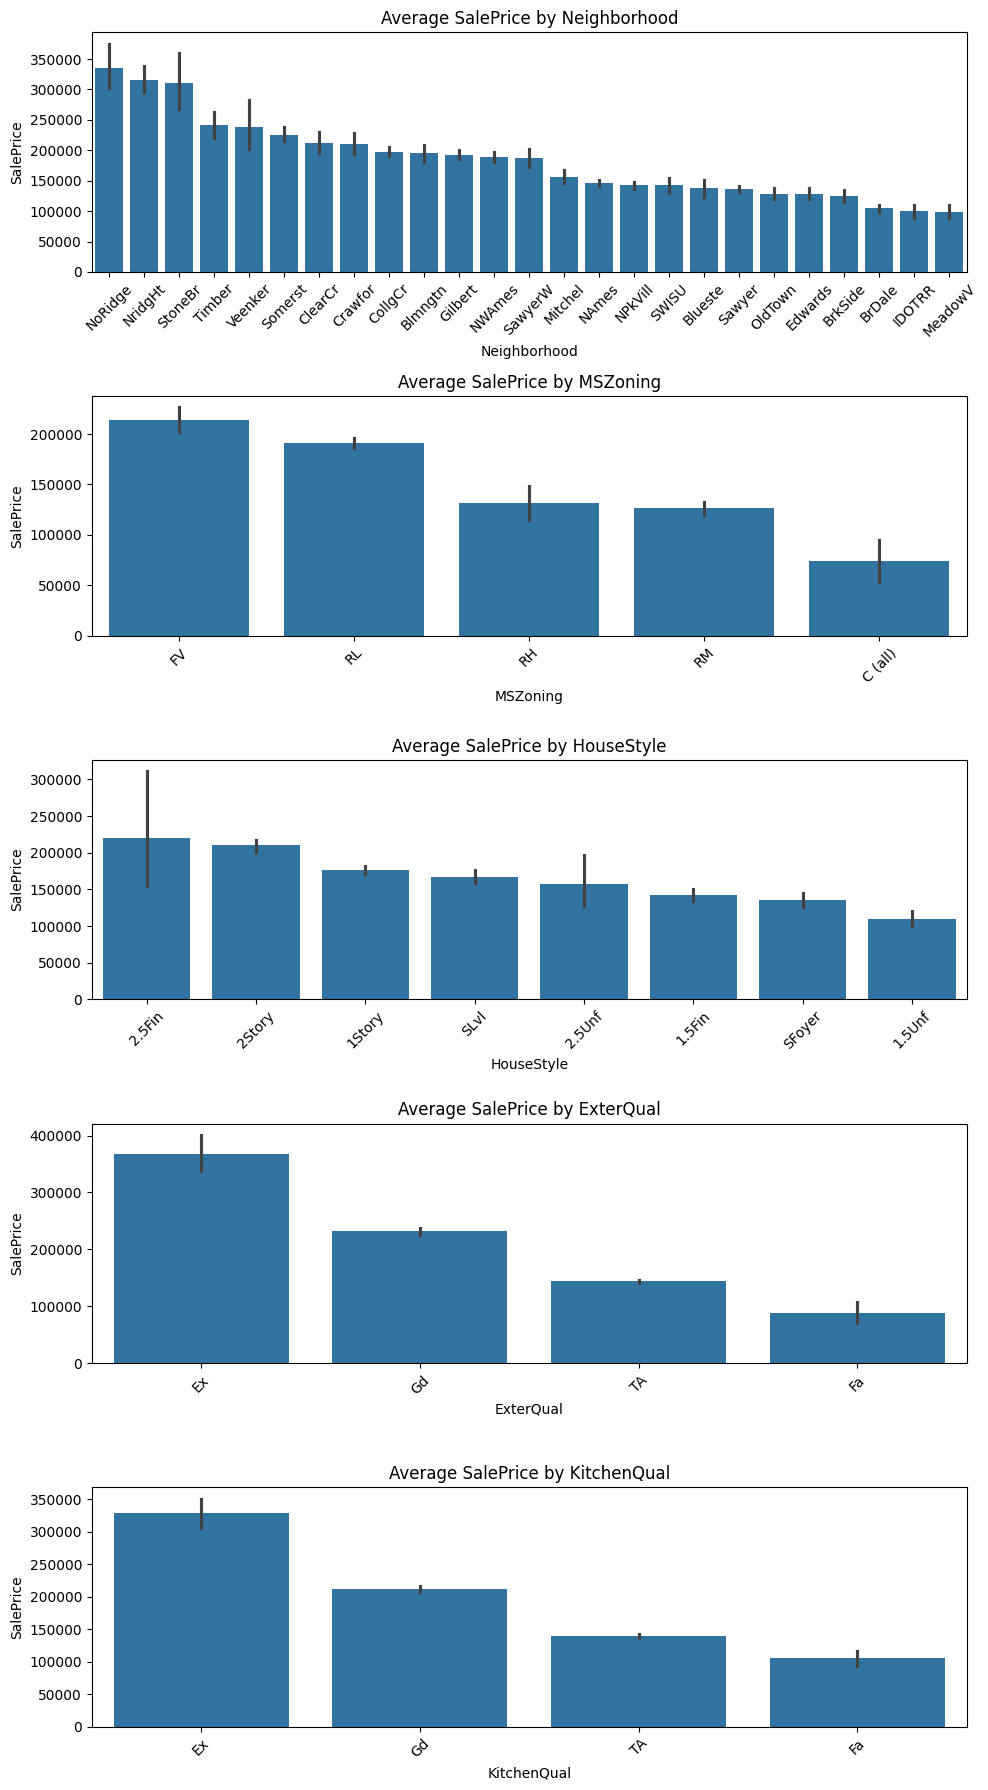

In [16]:
# 범주형 변수 추출
categorical_cols = df.select_dtypes(include='object').columns

# 각 범주형 변수별 SalePrice 평균 계산
category_price_summary = {}
for col in categorical_cols:
    if df[col].isnull().sum() == 0:  # 결측치 없는 변수만 분석
        grouped = df.groupby(col)['SalePrice'].mean().sort_values(ascending=False)
        category_price_summary[col] = grouped

# 상위 5개 유의미한 변수 선택 예시: Neighborhood, MSZoning, HouseStyle, ExterQual, KitchenQual
selected_cats = ['Neighborhood', 'MSZoning', 'HouseStyle', 'ExterQual', 'KitchenQual']
fig, axes = plt.subplots(len(selected_cats), 1, figsize=(10, 18))
for i, cat in enumerate(selected_cats):
    sns.barplot(x=df[cat], y=df['SalePrice'], ax=axes[i], order=df.groupby(cat)['SalePrice'].mean().sort_values(ascending=False).index)
    axes[i].set_title(f"Average SalePrice by {cat}")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("figures/category_saleprice_bars.png")

# Markdown 작성
cat_md = """
## 🧮 범주형 변수별 평균 SalePrice 분석

다음 범주형 변수들은 주택 가격과 뚜렷한 관련을 보입니다.  
범주에 따라 평균 `SalePrice` 차이가 뚜렷하므로, 범주형 인코딩 시 **순서형** 또는 **가중 인코딩**을 고려할 수 있습니다.

- `Neighborhood`: 거주지역에 따라 평균 가격 차이 큼 (예: NoRidge > StoneBr > Crawfor)
- `MSZoning`: 주거구역 등급에 따른 가격 차이
- `HouseStyle`: 주택 구조에 따른 차이 존재
- `ExterQual`, `KitchenQual`: 외장재 및 주방 품질 수준이 가격에 큰 영향

![범주형 변수별 평균 SalePrice](../figures/category_saleprice_bars.png)
"""

with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(cat_md)


In [20]:
from sklearn.preprocessing import OneHotEncoder

# 범주형 변수 중 선택한 5개에 대해 원핫 인코딩
cat_subset = df[selected_cats].dropna()
encoded = pd.get_dummies(cat_subset, drop_first=True)

# SalePrice를 결합하여 다중공선성 확인용 데이터프레임 구성
vif_input = pd.concat([encoded, df.loc[cat_subset.index, 'SalePrice']], axis=1).dropna()

# 스케일링
X_encoded = scaler.fit_transform(vif_input.drop(columns='SalePrice'))

# VIF 계산
vif_cat = pd.DataFrame()
vif_cat['Feature'] = vif_input.drop(columns='SalePrice').columns
vif_cat['VIF'] = [variance_inflation_factor(X_encoded, i) for i in range(X_encoded.shape[1])]

# 높은 VIF가 있는 feature만 필터링
high_vif_cat = vif_cat[vif_cat['VIF'] > 5].sort_values(by='VIF', ascending=False)

# 마크다운 정리
vif_cat_md = """
## 🧠 범주형 변수 다중공선성 점검 (One-Hot 인코딩 후)

선택된 범주형 변수들(`Neighborhood`, `MSZoning`, `HouseStyle`, `ExterQual`, `KitchenQual`)을 원-핫 인코딩 후 VIF를 계산하였습니다.

- 다수의 범주는 상호 독립적이지만 일부 고상관 범주가 존재
- 아래는 VIF > 5인 원-핫 인코딩된 컬럼 목록입니다:

| Feature | VIF |
|---------|-----|
""" + "\n".join([f"| {row.Feature} | {row.VIF:.2f} |" for _, row in high_vif_cat.iterrows()]) + """

- 예를 들어 `ExterQual_TA`와 `KitchenQual_TA`는 각각 "보통" 등급이며, 서로 유사한 품질 기준을 반영하는 경우 다중공선성 발생 가능
- 범주형 변수도 피처 선택 또는 통합 인코딩 전략이 필요할 수 있음
"""

# 결과 저장
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(vif_cat_md)

display(high_vif_cat)


,Feature,VIF
26,MSZoning_RL,36.525681
27,MSZoning_RM,24.724480
24,MSZoning_FV,13.386933
11,Neighborhood_NAmes,13.306186
37,ExterQual_TA,12.891635
36,ExterQual_Gd,10.330289
16,Neighborhood_OldTown,9.298972
4,Neighborhood_CollgCr,8.982407
20,Neighborhood_Somerst,8.684374
40,KitchenQual_TA,7.924437


,Id,GrLivArea,SalePrice
523,524,4676,184750
1298,1299,5642,160000


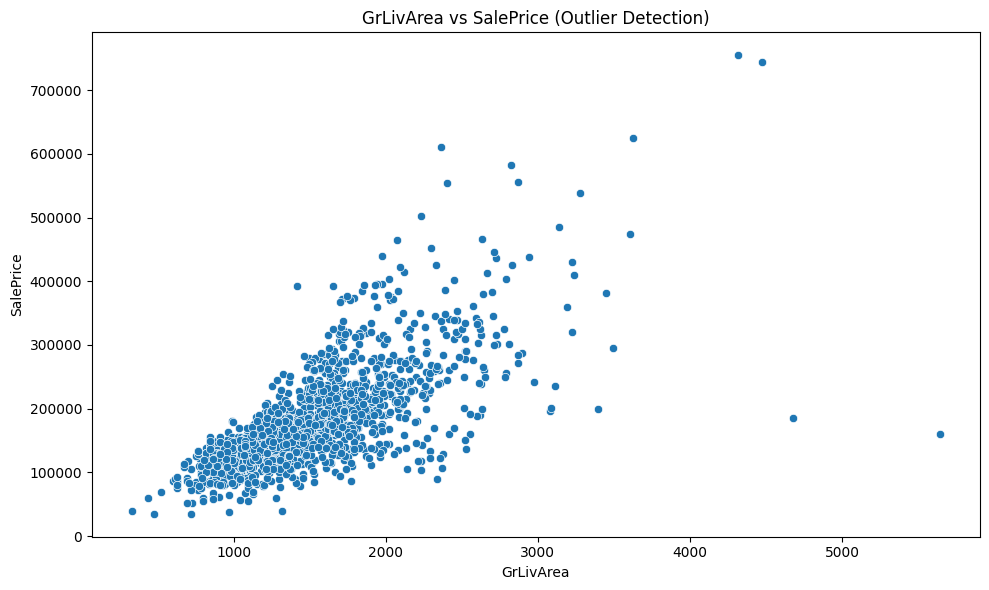

In [19]:
# SalePrice와 상관관계가 높은 상위 변수 중에서 이상치 탐지용으로 적절한 2개 변수 선정
# 예: GrLivArea, TotalBsmtSF → 면적 관련, 가격 대비 이상치 가능
outlier_df = df[['GrLivArea', 'TotalBsmtSF', 'SalePrice']]

# 시각화: GrLivArea vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(data=outlier_df, x='GrLivArea', y='SalePrice')
plt.title('GrLivArea vs SalePrice (Outlier Detection)')
plt.tight_layout()
plt.savefig("figures/outlier_grlivarea_saleprice.png")

# 이상치 탐지 기준 예시: GrLivArea > 4000 & SalePrice < 300000
outliers = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)]

# 이상치 수
num_outliers = len(outliers)

# Markdown 정리
outlier_md = f"""
## ⚠️ 이상치 탐지

### GrLivArea vs SalePrice
- 대부분의 샘플은 `GrLivArea < 4000`, `SalePrice < 500000` 범위에 분포
- 일부 **GrLivArea > 4000**이지만 **SalePrice < 300000**인 샘플은 **이상치**로 판단됨

- 이상치 샘플 수: {num_outliers}개

→ 이들 샘플은 회귀 모델에 **과도한 영향력**을 줄 수 있으므로 제거 또는 별도 처리 필요

![GrLivArea 이상치 시각화](../figures/outlier_grlivarea_saleprice.png)
"""

with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(outlier_md)

display(outliers[['Id', 'GrLivArea', 'SalePrice']])


,Id,TotalBsmtSF,SalePrice
1298,1299,6110,160000


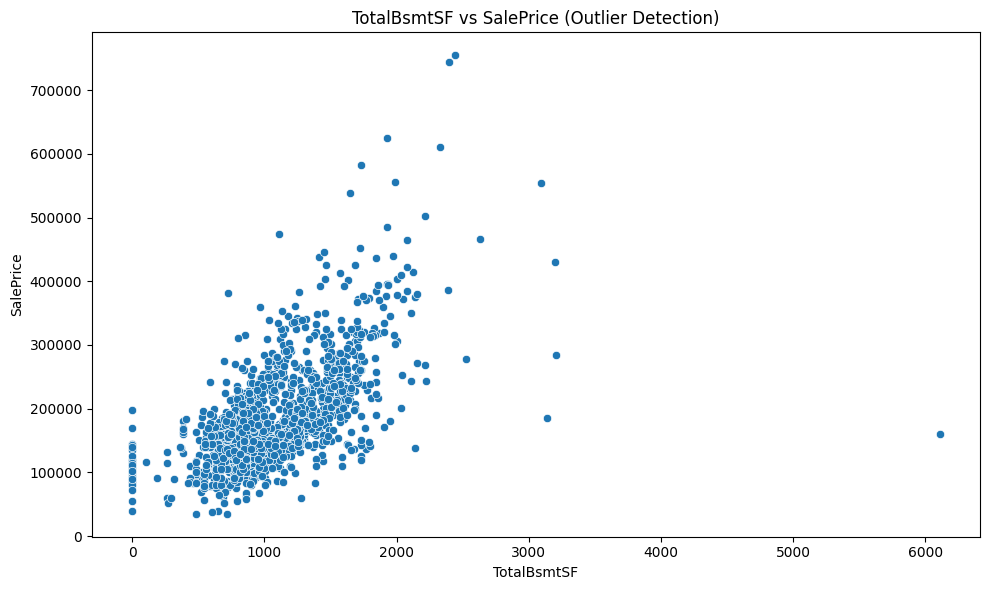

In [21]:
# 시각화: TotalBsmtSF vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(data=outlier_df, x='TotalBsmtSF', y='SalePrice')
plt.title('TotalBsmtSF vs SalePrice (Outlier Detection)')
plt.tight_layout()
plt.savefig("figures/outlier_totalbsmt_saleprice.png")

# 이상치 기준: TotalBsmtSF > 4000 & SalePrice < 300000
bsmt_outliers = df[(df['TotalBsmtSF'] > 4000) & (df['SalePrice'] < 300000)]

# 이상치 수
num_bsmt_outliers = len(bsmt_outliers)

# Markdown 정리
bsmt_outlier_md = f"""
### TotalBsmtSF vs SalePrice
- 대부분의 샘플은 `TotalBsmtSF < 4000`, `SalePrice < 500000` 범위에 있음
- `TotalBsmtSF > 4000` 이면서 `SalePrice < 300000`인 샘플은 이상치로 간주

- 이상치 샘플 수: {num_bsmt_outliers}개

→ 마찬가지로 모델에 영향을 줄 수 있으므로 검토 후 제거 고려

![TotalBsmtSF 이상치 시각화](../figures/outlier_totalbsmt_saleprice.png)
"""

# md에 추가
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(bsmt_outlier_md)

display(bsmt_outliers[['Id', 'TotalBsmtSF', 'SalePrice']])


In [22]:
# 결측치 수가 있는 컬럼 다시 정리
missing_df = df.isnull().sum()
missing_df = missing_df[missing_df > 0].sort_values(ascending=False)

# 결측 컬럼의 데이터 타입 확인
missing_types = df[missing_df.index].dtypes

# 결측 비율 계산
missing_ratio = (missing_df / len(df)).round(3)

# 결측 처리 전략 수립 테이블 생성
strategy = []
for col, dtype in missing_types.items():
    if missing_ratio[col] > 0.8:
        strat = "삭제 또는 'None' 대체 (희소 특성)"
    elif 'Garage' in col or 'Bsmt' in col:
        strat = "'None' 또는 0으로 대체 (특성 없음 의미)"
    elif 'Qual' in col or 'Cond' in col:
        strat = "최빈값 또는 'None' (품질 없음으로 해석 가능)"
    elif dtype == 'object':
        strat = "최빈값 또는 'Unknown'으로 대체"
    elif dtype in ['float64', 'int64']:
        strat = "중앙값 또는 그룹 평균으로 보간"
    else:
        strat = "검토 필요"
    strategy.append(strat)

missing_strategy = pd.DataFrame({
    'Column': missing_df.index,
    'MissingCount': missing_df.values,
    'MissingRatio': missing_ratio.values,
    'Dtype': missing_types.values,
    'ProposedStrategy': strategy
})

display(missing_strategy)


,Column,MissingCount,MissingRatio,Dtype,ProposedStrategy
0,PoolQC,1453,0.995,object,삭제 또는 'None' 대체 (희소 특성)
1,MiscFeature,1406,0.963,object,삭제 또는 'None' 대체 (희소 특성)
2,Alley,1369,0.938,object,삭제 또는 'None' 대체 (희소 특성)
3,Fence,1179,0.808,object,삭제 또는 'None' 대체 (희소 특성)
4,MasVnrType,872,0.597,object,최빈값 또는 'Unknown'으로 대체
5,FireplaceQu,690,0.473,object,최빈값 또는 'Unknown'으로 대체
6,LotFrontage,259,0.177,float64,중앙값 또는 그룹 평균으로 보간
7,GarageType,81,0.055,object,'None' 또는 0으로 대체 (특성 없음 의미)
8,GarageYrBlt,81,0.055,float64,'None' 또는 0으로 대체 (특성 없음 의미)
9,GarageFinish,81,0.055,object,'None' 또는 0으로 대체 (특성 없음 의미)


In [25]:
# 결측 유형 사전 (이전에 분석했던 내용 기반)
missing_type_map = {
    'PoolQC': 'MAR',
    'MiscFeature': 'MAR',
    'Alley': 'MAR',
    'Fence': 'MAR',
    'FireplaceQu': 'MAR',
    'LotFrontage': 'MAR',
    'GarageCond': 'MAR',
    'GarageQual': 'MAR',
    'GarageFinish': 'MAR',
    'GarageYrBlt': 'MAR',
    'GarageType': 'MAR',
    'BsmtExposure': 'MAR',
    'BsmtFinType2': 'MAR',
    'BsmtFinType1': 'MAR',
    'BsmtCond': 'MAR',
    'BsmtQual': 'MAR',
    'MasVnrArea': 'MAR',
    'MasVnrType': 'MAR',
    'Electrical': 'MCAR'
}

# 해당 정보를 컬럼으로 추가
missing_strategy["MissingType"] = missing_strategy["Column"].map(missing_type_map)

# Markdown 변환
md_table = missing_strategy.to_markdown(index=False)

# Markdown 정리
md_summary = f"""
## 🛠️ 결측치 처리 전략 및 결측 유형 요약

다음 표는 모든 결측 컬럼에 대한 결측 수, 비율, 데이터 타입, 결측 유형(MCAR/MAR), 처리 전략을 요약한 것입니다:

{md_table}
"""

# 파일에 추가
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(md_summary)
